# Impact of neglecting the self-demagnetization

### Import the required modules

In [1]:
%matplotlib inline
import numpy as np
from numpy.random import rand
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, BoundaryNorm
from matplotlib.colorbar import ColorbarBase
from matplotlib.cm import get_cmap
from fatiando import mesher, utils, gridder
from fatiando.gravmag import triaxial_ellipsoid

C:\Users\Vanderlei\Documents\fatiando\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
# Set some plot parameters
from matplotlib import rcParams
rcParams['figure.dpi'] = 300.
rcParams['font.size'] = 6
rcParams['xtick.labelsize'] = 'medium'
rcParams['ytick.labelsize'] = 'medium'
rcParams['axes.labelsize'] = 'large'
rcParams['legend.fontsize'] = 'medium'
rcParams['savefig.dpi'] = 300.

### Warrego magnetite body

In [3]:
# semi-axes (in m)
a = 490.7
b = 69.7
c = 30.

n11, n22, n33 = triaxial_ellipsoid.demag_factors(a, b, c)

In [4]:
print n11, n22, n33

0.0175129101631 0.292966215389 0.689520874448


In [5]:
print n11+n22+n33

1.0


In [6]:
# isotropic susceptibility (in SI)
chi_true = 1.690

In [7]:
# depth to center (in meter)
zc = 500.

### Orientation angles ($^{\circ}$)

In [8]:
#strike = 326. - 360.
strike = -34.
dip = 66.1
rake = 45.

alpha, gamma, delta = triaxial_ellipsoid.structural_angles(strike, dip, rake)
V = triaxial_ellipsoid.V(alpha, gamma, delta)

### Local-geomagnetic field (nT)

In [9]:
F_xyz = np.array([32610., 0., 39450.])
F, inc, dec = utils.vec2ang(F_xyz)

In [10]:
print F, inc, dec

51183.1476172 50.4223208627 0.0


In [11]:
F_local = np.dot(V.T, F_xyz)

In [12]:
print F_local

[-39396.00407387  -1162.86028241 -32654.51299553]


### Observation points (m)

In [13]:
area = [-2000., 2000., -2000., 2000.]
shape = (100, 100)
xp, yp, zp = gridder.regular(area, shape, z = 0.)

### Total-field anomaly (nT)

### $\chi = \chi_{true}$

In [14]:
# true magnetization in the main system
mag_true = triaxial_ellipsoid.magnetization(chi_true*np.identity(3),
                                            F, inc, dec, 0., 0., 0., V,
                                            axes = [a, b, c])

# approximated magnetization
mag_true_approx = triaxial_ellipsoid.magnetization(chi_true*np.identity(3),
                                            F, inc, dec, 0., 0., 0., V,
                                            axes = None)

# relative error
mag_true_norm = np.linalg.norm(mag_true, ord = 2)
mag_true_approx_norm = np.linalg.norm(mag_true_approx, ord = 2)
delta_mag_true_norm = np.linalg.norm(mag_true - mag_true_approx, ord = 2)
epsilon_true = delta_mag_true_norm/mag_true_norm

print 'epsilon = %.3f percent' % (epsilon_true*100)

epsilon = 42.820 percent


In [15]:
print mag_true, mag_true_norm

[ 31.51080683 -17.03128515  42.16016565] 55.3215616992


In [16]:
print mag_true_approx, mag_true_approx_norm

[ 43.85586077   0.          53.05469817] 68.834130496


In [17]:
np.allclose(mag_true_approx, chi_true*(F/(4*np.pi*100))*utils.ang2vec(1., inc, dec))

True

In [18]:
model_true = [mesher.TriaxialEllipsoid(0., 0., zc, a, b, c, strike, dip, rake,
                                       props = {'k': [chi_true, chi_true, chi_true, 0., 0., 0.]})]

In [19]:
tf_true = triaxial_ellipsoid.tf(xp, yp, zp, model_true, F, inc, dec)

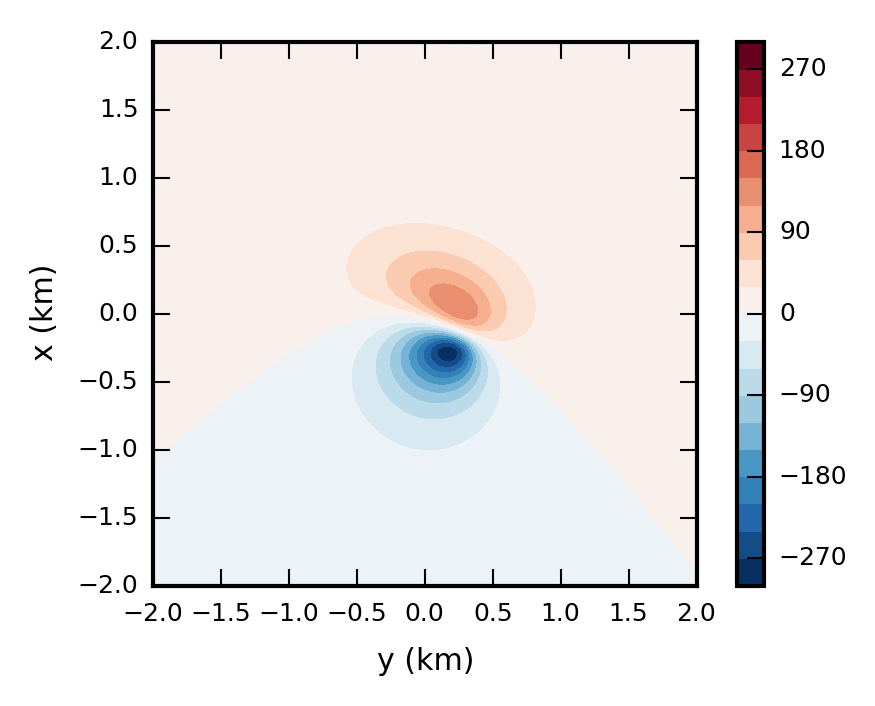

In [20]:
plt.figure(figsize=(3.15, 7./3))
plt.axis('scaled')

ranges = np.max(np.abs([np.min(tf_true), np.max(tf_true)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             tf_true.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()

plt.tight_layout()
plt.savefig('..\\manuscript\\figures\\total-field_anomaly.pdf', facecolor='w', bbox_inches='tight')

plt.show()

In [21]:
print 'max = %.3f' % (tf_true.max())
print 'min = %.3f' % (tf_true.min())
print 'peak-to-peak amplitude = %.3f' % (tf_true.max() - tf_true.min())

max = 149.551
min = -295.292
peak-to-peak amplitude = 444.843


In [22]:
tf_true_approx = triaxial_ellipsoid.tf(xp, yp, zp, model_true, F, inc, dec,
                                       dmag = False)

In [23]:
residuals_true = tf_true_approx - tf_true

In [24]:
print 'residuals min  = %.3f' % (residuals_true.min())
print 'residuals mean = %.3f' % (residuals_true.mean())
print 'residuals max  = %.3f' % (residuals_true.max())

residuals min  = -197.095
residuals mean = -1.275
residuals max  = 14.992


In [25]:
misfit_true = np.sum(residuals_true*residuals_true)/residuals_true.size

In [26]:
print 'misfit = %.3f' % misfit_true

misfit = 241.058


In [27]:
print 'peak-to-peak field amplitude = %.3f absolute' % \
(residuals_true.max() - residuals_true.min())

peak-to-peak field amplitude = 212.087 absolute


In [28]:
print 'peak-to-peak field amplitude = %.3f percent' % \
(100*(residuals_true.max() - residuals_true.min())/(tf_true.max() - tf_true.min()))

peak-to-peak field amplitude = 47.677 percent


### $\chi = 0.1$

In [29]:
# isotropic susceptibility commonly used as an upper limit
# to neglect the self-demagnetization
chi_usual = 0.1

# true magnetization in the main system
mag_usual = triaxial_ellipsoid.magnetization(chi_usual*np.identity(3),
                                             F, inc, dec, 0., 0., 0., V,
                                             axes = [a, b, c])

# approximated magnetization
mag_usual_approx = triaxial_ellipsoid.magnetization(chi_usual*np.identity(3),
                                                    F, inc, dec, 0., 0., 0., V,
                                                    axes = None)

# relative error
mag_usual_norm = np.linalg.norm(mag_usual, ord = 2)
mag_usual_approx_norm = np.linalg.norm(mag_usual_approx, ord = 2)
delta_mag_usual_norm = np.linalg.norm(mag_usual - mag_usual_approx, ord = 2)
epsilon_usual = delta_mag_usual_norm/mag_usual_norm

print 'epsilon = %.3f percent' % (epsilon_usual*100)

epsilon = 4.232 percent


In [30]:
print mag_usual, mag_usual_norm

[ 2.50895827 -0.12399384  3.06617603] 3.96379634975


In [31]:
print mag_usual_approx, mag_usual_approx_norm

[ 2.59502135  0.          3.13933125] 4.07302547314


In [32]:
np.allclose(mag_usual_approx, chi_usual*(F/(4*np.pi*100))*utils.ang2vec(1., inc, dec))

True

In [33]:
model_usual = [mesher.TriaxialEllipsoid(0., 0., zc, a, b, c, strike, dip, rake,
                                        props = {'k': [chi_usual, chi_usual, chi_usual, 0., 0., 0.]})]

In [34]:
tf_usual = triaxial_ellipsoid.tf(xp, yp, zp, model_usual, F, inc, dec)

In [35]:
tf_usual_approx = triaxial_ellipsoid.tf(xp, yp, zp, model_usual, F, inc, dec,
                                        dmag = False)

In [36]:
residuals_usual = tf_usual_approx - tf_usual

In [37]:
print 'residuals min  = %.3f' % (residuals_usual.min())
print 'residuals mean = %.3f' % (residuals_usual.mean())
print 'residuals max  = %.3f' % (residuals_usual.max())

residuals min  = -1.397
residuals mean = -0.009
residuals max  = 0.101


In [38]:
misfit_usual = np.sum(residuals_usual*residuals_usual)/residuals_usual.size

In [39]:
print 'misfit = %.3f' % misfit_usual

misfit = 0.012


In [40]:
print 'peak-to-peak field amplitude = %.3f absolute' % \
(residuals_usual.max() - residuals_usual.min())

peak-to-peak field amplitude = 1.498 absolute


In [41]:
print 'peak-to-peak field amplitude = %.3f percent' % \
(100*(residuals_usual.max() - residuals_usual.min())/(tf_usual.max() - tf_usual.min()))

peak-to-peak field amplitude = 4.458 percent


### $\chi = \chi_{max}$

In [42]:
# proposed upper maximum isotropic susceptibility
# to guarantee a relative error lower than or equal to epsilon
#epsilon_max = 0.07 # this epsilon generates a misfit similar 
                   # to that obtained by using the usual chi = 0.1
epsilon_max = 0.08
chi_max = epsilon_max/n33

print 'chi_max = %.3f SI' % chi_max

# true magnetization in the main system
mag_max = triaxial_ellipsoid.magnetization(chi_max*np.identity(3),
                                           F, inc, dec, 0., 0., 0., V,
                                           axes = [a, b, c])

# approximated magnetization
mag_max_approx = triaxial_ellipsoid.magnetization(chi_max*np.identity(3),
                                                  F, inc, dec, 0., 0., 0., V,
                                                  axes = None)

# relative error
mag_max_norm = np.linalg.norm(mag_max, ord = 2)
mag_max_approx_norm = np.linalg.norm(mag_max_approx, ord = 2)
delta_mag_max_norm = np.linalg.norm(mag_max - mag_max_approx, ord = 2)

epsilon_calculated = delta_mag_max_norm/mag_max_norm

print 'epsilon = %.3f percent' % (epsilon_calculated*100)

chi_max = 0.116 SI
epsilon = 4.879 percent


In [43]:
print mag_max, mag_max_norm

[ 2.89612836 -0.16516041  3.54480438] 4.58044491011


In [44]:
print mag_max_approx, mag_max_approx_norm

[ 3.01081106  0.          3.64233353] 4.72562978042


In [45]:
np.allclose(mag_max_approx, chi_max*(F/(4*np.pi*100))*utils.ang2vec(1., inc, dec))

True

In [46]:
model_max = [mesher.TriaxialEllipsoid(0., 0., zc, a, b, c, strike, dip, rake,
                                      props = {'k': [chi_max, chi_max, chi_max, 0., 0., 0.]})]

In [47]:
tf_max = triaxial_ellipsoid.tf(xp, yp, zp, model_max, F, inc, dec)

In [48]:
tf_max_approx = triaxial_ellipsoid.tf(xp, yp, zp, model_max, F, inc, dec,
                                      dmag = False)

In [49]:
residuals_max = tf_max_approx - tf_max

In [50]:
print 'residuals min  = %.3f' % (residuals_max.min())
print 'residuals mean = %.3f' % (residuals_max.mean())
print 'residuals max  = %.3f' % (residuals_max.max())

residuals min  = -1.861
residuals mean = -0.012
residuals max  = 0.135


In [51]:
misfit_max = np.sum(residuals_max*residuals_max)/residuals_max.size

In [52]:
print 'misfit = %.3f' % misfit_max

misfit = 0.021


In [53]:
print 'peak-to-peak field amplitude = %.3f absolute' % \
(residuals_max.max() - residuals_max.min())

peak-to-peak field amplitude = 1.996 absolute


In [54]:
print 'peak-to-peak field amplitude = %.3f percent' % \
(100*(residuals_max.max() - residuals_max.min())/(tf_max.max() - tf_max.min()))

peak-to-peak field amplitude = 5.143 percent


### Comparison

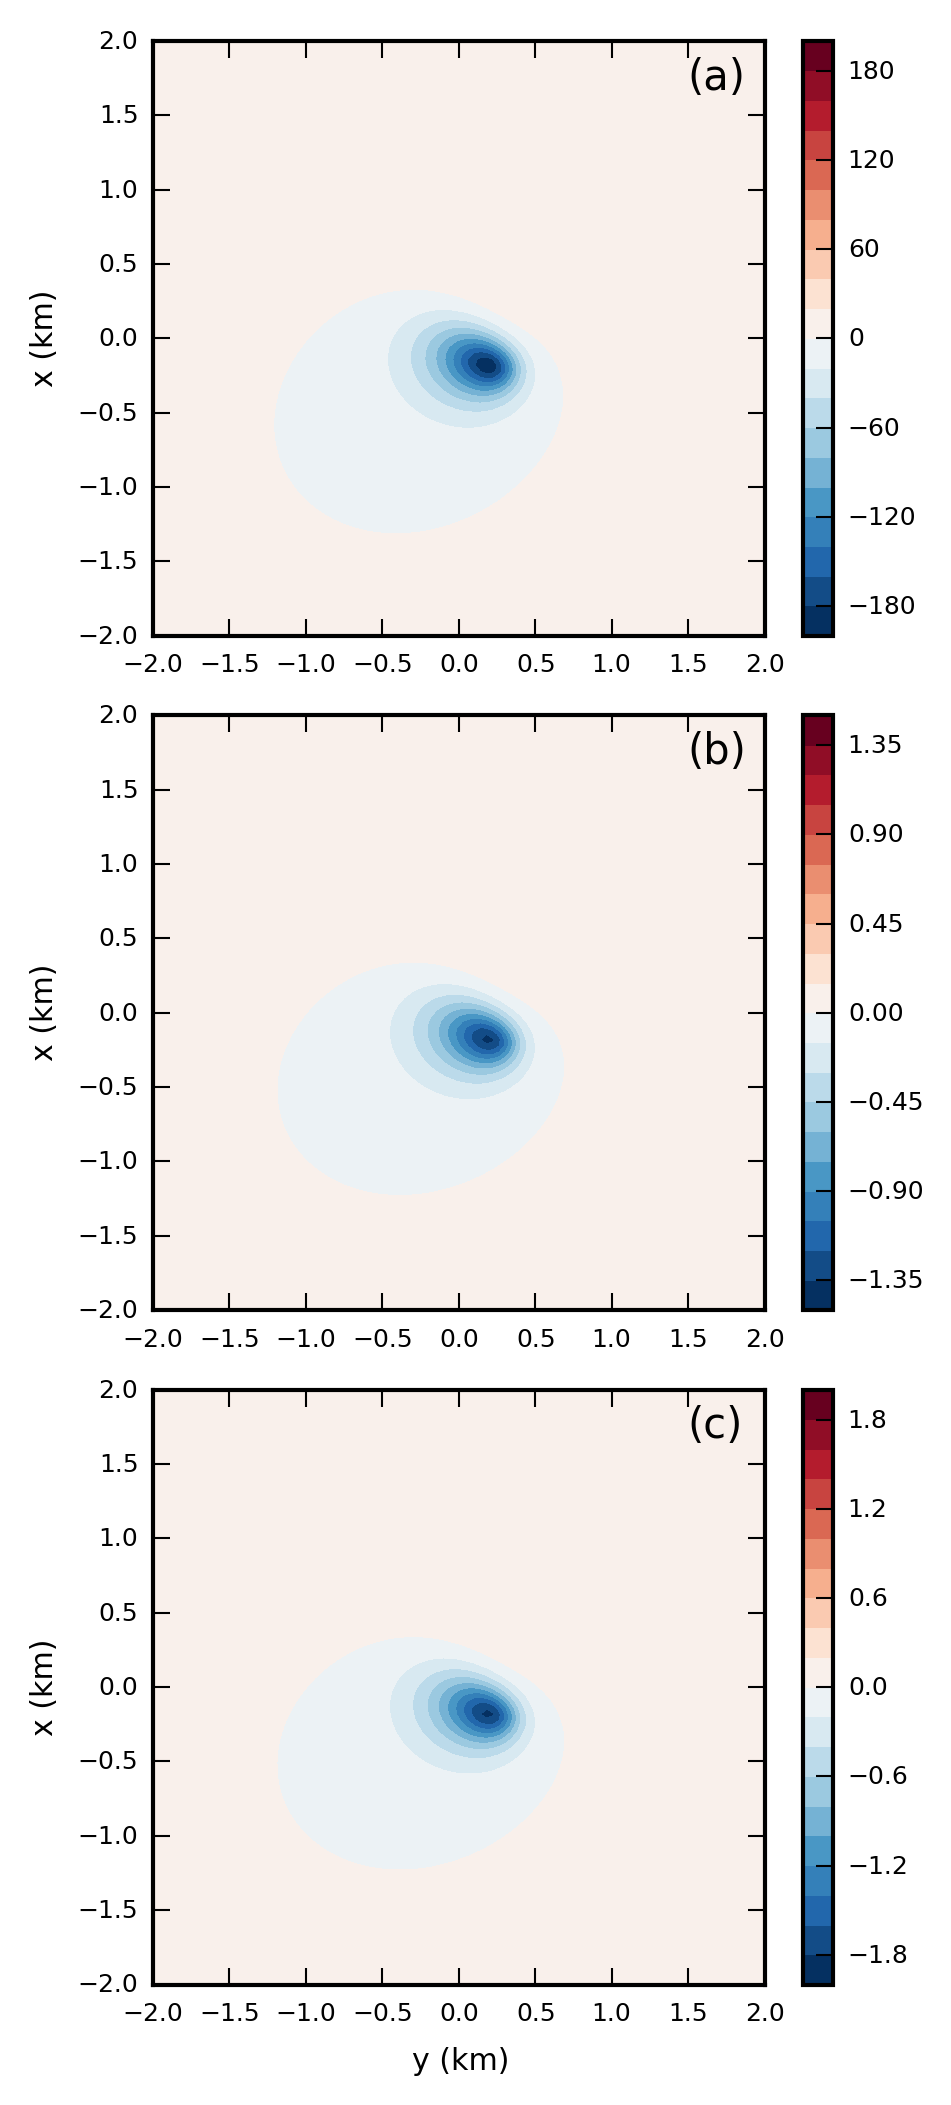

In [55]:
plt.figure(figsize=(3.15, 7))
plt.axis('scaled')

ranges = np.max(np.abs([np.min(residuals_true), np.max(residuals_true)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
plt.subplot(3,1,1)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             residuals_true.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
cbar = plt.colorbar()
plt.annotate(s='(a)', xy=(0.88,0.92),
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

ranges = np.max(np.abs([np.min(residuals_usual), np.max(residuals_usual)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(3,1,2)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             residuals_usual.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
plt.colorbar()
plt.annotate(s='(b)', xy=(0.88,0.92),
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

ranges = np.max(np.abs([np.min(residuals_max), np.max(residuals_max)]))
levels = MaxNLocator(nbins=20).tick_values(-ranges, ranges)
cmap = plt.get_cmap('RdBu_r')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

plt.subplot(3,1,3)
plt.contourf(0.001*yp.reshape(shape), 0.001*xp.reshape(shape),
             residuals_max.reshape(shape), levels=levels,
             cmap = cmap, norm=norm)
plt.ylabel('x (km)')
plt.xlabel('y (km)')
plt.xlim(0.001*np.min(yp), 0.001*np.max(yp))
plt.ylim(0.001*np.min(xp), 0.001*np.max(xp))
plt.colorbar()
plt.annotate(s='(c)', xy=(0.88,0.92), 
             xycoords = 'axes fraction', color='k',
             fontsize = 10)

plt.tight_layout()
plt.savefig('..\\manuscript\\figures\\field_differences.pdf', facecolor='w', bbox_inches='tight')

plt.show()